#### Make sure the python is used from your newly created environment

In [1]:
# Check the location from where the python executable is coming from
import sys
print(sys.executable)

C:\Users\Ashwin\anaconda3\envs\mlflowIntro\python.exe


In [2]:
!python --version

Python 3.9.16


In [4]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: E:\JupyterNotebooks


In [5]:
import pandas as pd
import numpy as np

In [6]:
def load_data(path):
    data = pd.read_csv(path)
    return data

In [33]:
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("After dropping na values \n")
    print(data.isna().sum())
    return data

In [46]:
def preprocessing(data):
    data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])    
    data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])    
    
    cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for var in cat_vars:
        cat_list = 'var' + '_' + var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data = data.join(cat_list)
        
    data_vars = data.columns.values.tolist()
    to_keep = [i for i in data_vars if i not in cat_vars]
    
    final_data = data[to_keep]
    
    final_data.columns = final_data.columns.str.replace('.', '_')
    final_data.columns = final_data.columns.str.replace(' ', '_')
    return final_data

In [12]:
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=47)
    return x_train, x_test, y_train, y_test

In [21]:
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
 
    return X_train, y_train
    

In [22]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

In [23]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [24]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [25]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [64]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn.metrics import RocCurveDisplay
    roc_curve = RocCurveDisplay.from_estimator(clf, X_test, y_test)
    roc_curve.figure_.suptitle("ROC curve comparison")
    plt.savefig('roc_auc_curve.png')

In [89]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.savefig('confusion_matrix.png')

In [28]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [30]:
data = load_data('./dataset/banking.csv')
data.head().T

,0,1,2,3,4
age,44,53,28,39,55
job,blue-collar,technician,management,services,retired
marital,married,married,single,married,married
education,basic.4y,unknown,university.degree,high.school,basic.4y
default,unknown,no,no,no,no
housing,yes,no,yes,no,yes
loan,no,no,no,no,no
contact,cellular,cellular,cellular,cellular,cellular
month,aug,nov,jun,apr,aug
day_of_week,thu,fri,thu,fri,fri


In [31]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [34]:
cleaned_data = data_cleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
After dropping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [47]:
final_data = preprocessing(cleaned_data)

C:\Users\Ashwin\AppData\Local\Temp\ipykernel_17916\2914325629.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data.columns = final_data.columns.str.replace('.', '_')


In [48]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [49]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [50]:
model = training_basic_classifier(X_train,y_train)

In [51]:
y_pred = predict_on_test_data(model,X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [52]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)
y_pred_prob

array([[1.        , 0.        ],
       [0.99009901, 0.00990099],
       [0.85148515, 0.14851485],
       ...,
       [1.        , 0.        ],
       [0.67326733, 0.32673267],
       [0.99009901, 0.00990099]])

In [53]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [54]:
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.51, 'entropy': 0.2}


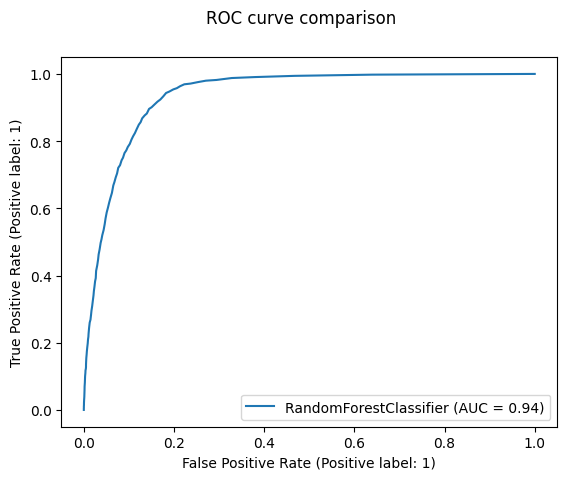

In [65]:
create_roc_auc_plot(model, X_test, y_test)

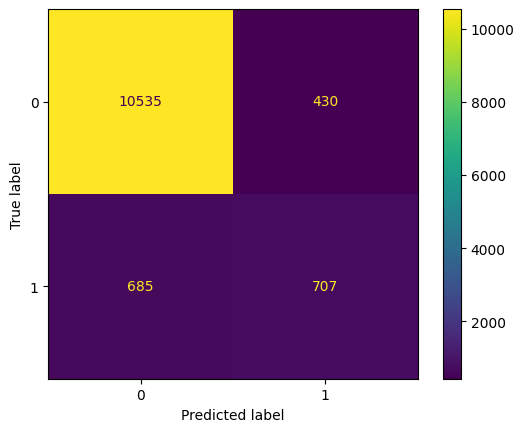

In [90]:
create_confusion_matrix_plot(model, X_test, y_test)

In [74]:
y_test['y'].value_counts()

0    10965
1     1392
Name: y, dtype: int64

# MLFlow work Starts from here

In [83]:
!mlflow --version # check mlflow version installed

mlflow, version 2.1.1


#### Function to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc

In [95]:
def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path = None, roc_auc_plot_path = None,
                      run_params=None):
    import mlflow
    # mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database 
    # like sqlite as backend storage for model
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)
    
                            
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [99]:
experiment_name = "basic_classifier" ##basic classifier
run_name="term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.54, 'entropy': 0.2}


In [100]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

2023/02/24 23:51:18 INFO mlflow.tracking.fluent: Experiment with name 'basic_classifier' does not exist. Creating a new experiment.


Run - term_deposit is logged to Experiment - basic_classifier


#### Create another experiment after tuning hyperparameters and log the best set of parameters for which model gives the optimal performance

In [91]:
import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 21, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}  



In [85]:
run_metrics

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.55, 'entropy': 0.2}

In [86]:
for param in run_params:
    print(param, run_params[param])

n_estimators 51
min_samples_split 6
min_samples_leaf 3
max_features sqrt
max_depth 70
bootstrap True


In [98]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model


### if want to use the model registry feature, we need a database.

#### _If you have MySQL installed then you can use the below command:

1. Create a database to use as an MLflow backend tracking server.

`CREATE DATABASE mlflow_tracking_database;`

2. Start MLflow tracking server using MySQL as a backend tracking store.

` mlflow server --backend-store-uri  mysql+pymysql://root@localhost/mlflow_tracking_database --default-artifact-root  file:/./mlruns -h 0.0.0.0 -p 5000`

3. Set the MLflow tracking uri (within code section).

mlflow.set_tracking_uri(\"http://localhost:5000\")

#### _If you have sqlite installed then you can use the below command:

1. Start MLflow tracking server using sqlite as a backend tracking store.

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000`

2. Set the MLflow tracking uri (within code section).

mlflow.set_tracking_uri(\"http://localhost:5000\")

You can also follow the official documentation for more information on backend database for model registry
https://www.mlflow.org/docs/latest/model-registry.html#model-registry-workflows